Importig Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

Load and Explore the Dataset

In [7]:
train_df = pd.read_csv('twitter_training.csv',header=None)

In [9]:
# Assign meaningful column names
train_df.columns = ['ID', 'Entity', 'Sentiment', 'Message']

In [11]:
# Display basic dataset info
print("Dataset Info:")
print(train_df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         74682 non-null  int64 
 1   Entity     74682 non-null  object
 2   Sentiment  74682 non-null  object
 3   Message    73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB
None


In [13]:
# View the first few records
print("\nSample Data:")
print(train_df.head())


Sample Data:
     ID       Entity Sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                             Message  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  


In [15]:
# Check for missing values
print("\nMissing Values:")
print(train_df.isnull().sum())


Missing Values:
ID             0
Entity         0
Sentiment      0
Message      686
dtype: int64


Data Preprocessing and Cleaning

In [18]:
import re

# Define text cleaning function
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)  # Remove special characters
    text = text.lower().strip()  # Convert to lowercase
    return text

In [20]:
# Apply cleaning
train_df['Message'] = train_df['Message'].astype(str).apply(clean_text)


In [22]:
# Remove missing sentiment values
train_df.dropna(subset=['Sentiment'], inplace=True)

In [24]:
# Convert sentiment labels to numerical values
sentiment_mapping = {'Positive': 1, 'Negative': 0, 'Neutral': 2}
train_df['Sentiment'] = train_df['Sentiment'].map(sentiment_mapping)

In [26]:
# Remove any remaining NaN values after mapping
train_df.dropna(subset=['Sentiment'], inplace=True)

In [28]:
# Convert Sentiment to integer
train_df['Sentiment'] = train_df['Sentiment'].astype(int)

In [30]:
# Check unique sentiment values
print("\nUnique sentiment values after encoding:", train_df['Sentiment'].unique())


Unique sentiment values after encoding: [1 2 0]


Feature Extraction Using TF-IDF

In [33]:
# Convert text messages to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=15000, stop_words='english', ngram_range=(1,2))
X = vectorizer.fit_transform(train_df['Message'])
y = train_df['Sentiment']

print("Shape of feature matrix:", X.shape)

Shape of feature matrix: (61692, 15000)


Splitting the Data for Training and Testing

In [36]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print dataset sizes
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)


Training set size: (49353, 15000)
Testing set size: (12339, 15000)


Model Training Using Logistic Regression

In [39]:
# Define Logistic Regression model
model = LogisticRegression(max_iter=2000)

# Define parameter grid for tuning
parameters = {'C': [0.01, 0.1, 1, 10, 50, 100]}

# Perform Grid Search to find best hyperparameters
grid_search = GridSearchCV(model, parameters, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get best parameter
best_param = grid_search.best_params_
print("Best Parameters:", best_param)

# Train final model using best parameter
best_model = LogisticRegression(C=best_param['C'], max_iter=2000)
best_model.fit(X_train, y_train)

# Make predictions on test data
y_pred = best_model.predict(X_test)

Best Parameters: {'C': 50}


Model Evaluation

In [41]:
# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Model Accuracy: 0.8525812464543318
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.85      0.87      4509
           1       0.83      0.88      0.85      4180
           2       0.84      0.82      0.83      3650

    accuracy                           0.85     12339
   macro avg       0.85      0.85      0.85     12339
weighted avg       0.85      0.85      0.85     12339



Visualizing Confusion Matrix

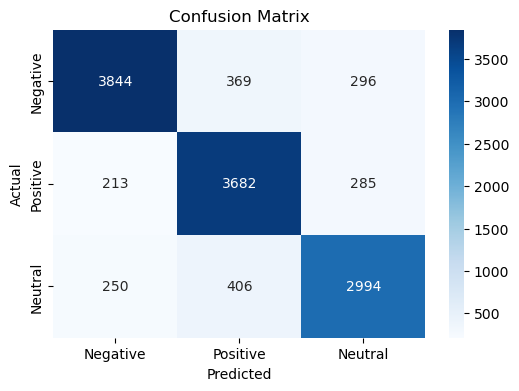

In [45]:
# Create and visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive', 'Neutral'], yticklabels=['Negative', 'Positive', 'Neutral'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Save the Model and Vectorizer

In [48]:
import joblib

# Save the trained model and vectorizer for future use
joblib.dump(best_model, 'sentiment_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

print("Model and vectorizer saved successfully.")

Model and vectorizer saved successfully.


Make Predictions on New Data

In [51]:
# Function to predict sentiment of a new message
def predict_sentiment(message):
    message_cleaned = clean_text(message)
    message_vectorized = vectorizer.transform([message_cleaned])
    prediction = best_model.predict(message_vectorized)
    
    sentiment_label = {0: 'Negative', 1: 'Positive', 2: 'Neutral'}
    return sentiment_label[prediction[0]]

# Test the function
new_message = "I love this product! It's amazing."
print("Predicted Sentiment:", predict_sentiment(new_message))


Predicted Sentiment: Positive
